# Land Surface Temperature  (LST) e imagen real

En este notebook se hara el cálculo de LST (Land Surface Temperature). Se exploraran 2 métodos, uno "from scratch" que consta en utilizar las imagenes satelitales, varias bandas espeisficamente la _______ y hacer los cálculos  para la estimación de la tempertura superficial.

El otro método es más directo, pues usa los datos ya procesados de Landsat que ya tienen la temperatura calculada, simlemente hace una tranformación de las unidades de los pixeles.

Para ambos casos es indispensable el uso de **LANDSAT 9** debido a que este satelite cuenta con bandas terminas. Espesificaente las  que se muestran en la siguiente table:


<div style="text-align: center;">
    <img src="Images/bandas termincas landsat 9.png" alt="Descripción de la imagen" width="500">
</div>





**IMPORTACION DE LIBRERIAS**

In [1]:
import ee
import geemap
import os
import pandas as pd
import json
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib_scalebar.scalebar import ScaleBar  # <-- for the scale bar

## 1) Autentificación


In [2]:
# 1) Obtención de la dirección de trabajo
direction = os.getcwd()

# Remove the last part of the path
direction = os.path.dirname(direction)

# Dirección de la llave
service_account = direction + '/conf/local/gcp-for-data-science-397913-4fd843feede1.json'

# Autentificación
credentials = ee.ServiceAccountCredentials(email=None, key_file=service_account)
ee.Initialize(credentials)

## 2) Importación de datos


**NOMBRES DE LAS IMAGENES**

In [3]:
images_names = pd.read_csv(filepath_or_buffer=direction + "/data/02_intermediate/Landsat_images_names.csv")
images_names.head(n=4)

,Images names
0,Image_2024-10-11 00:00:00
1,Image_2024-10-27 00:00:00
2,Image_2024-11-12 00:00:00
3,Image_2024-11-28 00:00:00


**AREA DE INTRERES (AOI)**

In [4]:
# Dirección
geojson_file =  direction + "/data/01_raw/AOI.geojson"

# Step 1: Load the GeoJSON file
with open(geojson_file, "r") as f:
    geojson_data = json.load(f)

**Convertilor a una geometria de earth engine**

In [5]:
area_interest = ee.Geometry(geojson_data)
type(area_interest)

ee.geometry.Geometry

## 3) Procesamiento

**CREACION DEL MAPA WEB BASE**

Se utilizara para inspeccionar las imagenes

In [6]:
# 1) Creación del mapa base
Map = geemap.Map()

# Central el mapa
Map.centerObject(ee_object=area_interest, zoom= 10)

# 2) Definir la paleta de colores personalizada, es una paleta que va del verde al rojo
palette = [
    "#008000", "#1B9908", "#37B110", "#53C918", "#6FE120", "#91E51D",
    "#B1E91B", "#D1ED19", "#F1F117", "#F6D80F", "#FAC008", "#FFA500",
    "#FF8500", "#FF6500", "#FF4500", "#FF2E00", "#FF1700", "#FF0000"
]


# 3) LST parameters
lst_vis = {
"min": 0,
"max": 50,
"palette": palette,
"bands": "LST_C"}


# 4) Parámetros para la visualización en color rel
# Add the image to the map with a Natural Color visualization
real_vis = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # Corrected the syntax for bands
    'min': 8000,                           # Adjusted for Landsat reflectance values
    'max': 17000
    }

### 3.1) Uso de ST_10

La ST_10 ya es una banda procesda.... ampliar esto

En erth engine ya tiene sets de datos de imagnees con las temperturas procesadas con landsat 9. En este apartando  voy a ir explicando paso a paso este proceos.

Esto se logra usando la banda ST_B10, la cual representa la temperatura de la superficie terrestre en Kelvin (K). ST_B10 es el resultado de la aplicación de correcciones atmosféricas y de emisividad.

Nivel 2 (L2): Estos productos ya están procesados y calibrados, por lo que no es necesario calcular la temperatura de brillo (BT) o aplicar fórmulas adicionales para obtener la temperatura superficial. Landsat 9 Collection 2, Nivel 2 (L2) realiza las correcciones atmosféricas durante el preprocesamiento de los datos. La banda térmica ST_B10 proporciona directamente la temperatura superficial, lo que ahorra tiempo y reduce la complejidad del análisis.


______

In the Collection 2, Level-2 product, the thermal band used for surface temperature is typically named ST_B10. This band is already corrected for atmospheric effects and provides an at-satellite brightness temperature, or in some products, an estimated surface temperature in Kelvin. However, you still need to apply the scale factor (and sometimes an additive offset) to convert digital numbers to actual temperature.




Los factores de escala puede encontrarse en la documentación oficial de USGS:

https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products

In the Collection 2, Level-2 product, the thermal band used for surface temperature is typically named ST_B10. This band is already corrected for atmospheric effects and provides an at-satellite brightness temperature, or in some products, an estimated surface temperature in Kelvin. However, you still need to apply the scale factor (and sometimes an additive offset) to convert digital numbers to actual temperature.

[According to USGS documentation (for Landsat Collection 2 Level-2 products)](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products):

ST_B10 (Surface Temperature band) has a scale factor of 0.00341802 (this factor might be subject to slight differences in product documentation, but is typical).
An additional offset of 149.0 K is often used.


<div style="text-align: center;">
    <img src="Images/Coorection factors.png" alt="Descripción de la imagen" width="500">
</div>


<div style="text-align: center;">
    <img src="Images/Formula DN to K.png" alt="Descripción de la imagen" width="500">
</div>


**INICIO DEL PROCESAMIENTO**

**GENERACION DE LA IMAGEN DE TEMPERATURA SUPRFICIAL Y COLOR REAL**

In [7]:
# Diccionario vacio
lst_dic = {}

# Iteramos sobre el nombre de las imagenes
for i in images_names["Images names"]:

    # 1) Lectura de la imagen
    path = f"gs://earth_engine_selene/Landsat/Row_Data/{i}.tif" # Estos archivos tienen las bandas sin procesamiento
    image = ee.Image.loadGeoTIFF(uri=path)

    # 2) Corte de la imagen al área de interés
    image = image.clip(clip_geometry=area_interest)

   # 3) Select the thermal band ST_B10 (Surface Temperature band)
    thermal_band = image.select(selectors=["ST_B10"])

    # Apply scale factor and offset for Landsat 9 L2
    # DN * 0.00341802 + 149.0 => Kelvin
    # Then subtract 273.15 to get Celsius
    lst_celsius = thermal_band.multiply(0.00341802).add(149.0).subtract(273.15) # Vease como uso los métodos (funciones) de EE.

    # Rename the band to 'LST_C'
    lst_celsius = lst_celsius.rename('LST_C')

    # 4) Generación de imagen real
    real_image = image.select(selectors=["SR_B4", "SR_B3", "SR_B2"]) # Seleccionamos en orden RGB las bandas

    # 5) Se añade al mapa base web
    Map.addLayer(ee_object=lst_celsius,  vis_params= lst_vis, name=f'LST {i}', shown=False)
    Map.addLayer(ee_object=real_image,  vis_params= real_vis, name=f'Real Imagen {i}', shown=False)

    # 6) Exportación de resultados
    # 6.1) Exportación de LST
    task = ee.batch.Export.image.toCloudStorage(
    image=lst_celsius,
    #description=f"Export", # Este es el nombre del archivo que se exportara , si vas a usar el filenameprexi no es necesario esto
    bucket='earth_engine_selene',  # Cambia esto al nombre de tu bucket
    fileNamePrefix=f"Landsat/LST/{i}", # Damos una dirección dentro del bucket y le damos nombre
    scale=30,  # Resolución en metros
    fileFormat='GeoTIFF')  # Formato de archivo

    task.start()  # Inicia la tarea de exportación
    print("Se exportó la imagen a Cloud Storage:", i)

    # 6.2) Exportación de la imagen real
    task_2 = ee.batch.Export.image.toCloudStorage(
    image=real_image,
    #description=f"Export", # Este es el nombre del archivo que se exportara , si vas a usar el filenameprexi no es necesario esto
    bucket='earth_engine_selene',  # Cambia esto al nombre de tu bucket
    fileNamePrefix=f"Landsat/Real_Image/{i}", # Damos una dirección dentro del bucket y le damos nombre
    scale=30,  # Resolución en metros
    fileFormat='GeoTIFF')

    task_2.start()

Se exportó la imagen a Cloud Storage: Image_2024-10-11 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-10-27 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-12 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-28 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-14 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-30 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-10-02 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-10-18 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-19 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-05 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-21 00:00:00
Se exportó la imagen a Cloud Storage: Image_2025-01-06 00:00:00


**VISUALIZACION DEL MAPA WEB** 

In [8]:
Map

Map(center=[24.77862463999283, -107.65760939283743], controls=(WidgetControl(options=['position', 'transparent…

## 4) Generación de mapas estáticos 

In [9]:
# Autentificacion , variables del sistema
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =  service_account

### 4.1) Mapas estáticos de temperatura superficial

In [29]:
cmap = ListedColormap(colors=palette) # Esto crea una lista de colores que puede ser integrado directamente en la figura


for i in images_names["Images names"]:
    # Ruta del archivo TIFF
    tiff_path = f"gs://earth_engine_selene/Landsat/LST/{i}.tif"

    # Lectura del archivo
    with rasterio.open(tiff_path) as src:
        # Lectura del archivo
        raster_data = src.read(1) # Creo que aqui se selecciona la banda de la imagen, hay que confirmar

        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot del raster con la paleta personalizada y escala fija
        img = ax.imshow(raster_data, cmap=cmap, vmin=0, vmax=50) # <-- Set vmin and vmax here

        # Añadir una barra de colores (leyenda de NDVI)
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Temperature')

        # -------------------------------------------------
        # AÑADIR LA BARRA DE ESCALA (ScaleBar)
        # -------------------------------------------------
        # (1) Obtener la resolución de pixel (asumiendo un CRS en metros, por ejemplo UTM)
        pixel_size_x = abs(src.transform[0])  # tamaño de pixel en X (ej. metros)

        # (2) Crear y añadir la ScaleBar
        scalebar = ScaleBar(
            pixel_size_x,
            units='m',         # 'm' para metros, 'km' si desea kilómetros
            location='lower left',  # use espacio, no subrayado (p.ej. "lower left")
            length_fraction=0.25    # porcentaje del ancho del eje que ocupa la scale bar
        )
        ax.add_artist(scalebar)

        # Quitar los valores de los ejes X e Y
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Añadir título
        ax.set_title(f"Temperature {i}")

        # Guardar la figura en un archivo .png
        fig.savefig(direction + f"/data/07_model_output/LST/static maps/LST_{i}.png")

        # Cerrar la figura para no mostrarla en pantalla
        plt.close(fig)

        print("Exportación de:", {i})

Exportación de: {'Image_2024-10-11 00:00:00'}
Exportación de: {'Image_2024-10-27 00:00:00'}
Exportación de: {'Image_2024-11-12 00:00:00'}
Exportación de: {'Image_2024-11-28 00:00:00'}
Exportación de: {'Image_2024-12-14 00:00:00'}
Exportación de: {'Image_2024-12-30 00:00:00'}
Exportación de: {'Image_2024-10-02 00:00:00'}
Exportación de: {'Image_2024-10-18 00:00:00'}
Exportación de: {'Image_2024-11-19 00:00:00'}
Exportación de: {'Image_2024-12-05 00:00:00'}
Exportación de: {'Image_2024-12-21 00:00:00'}
Exportación de: {'Image_2025-01-06 00:00:00'}


### 4.2) Mapas estáticos de imagen real

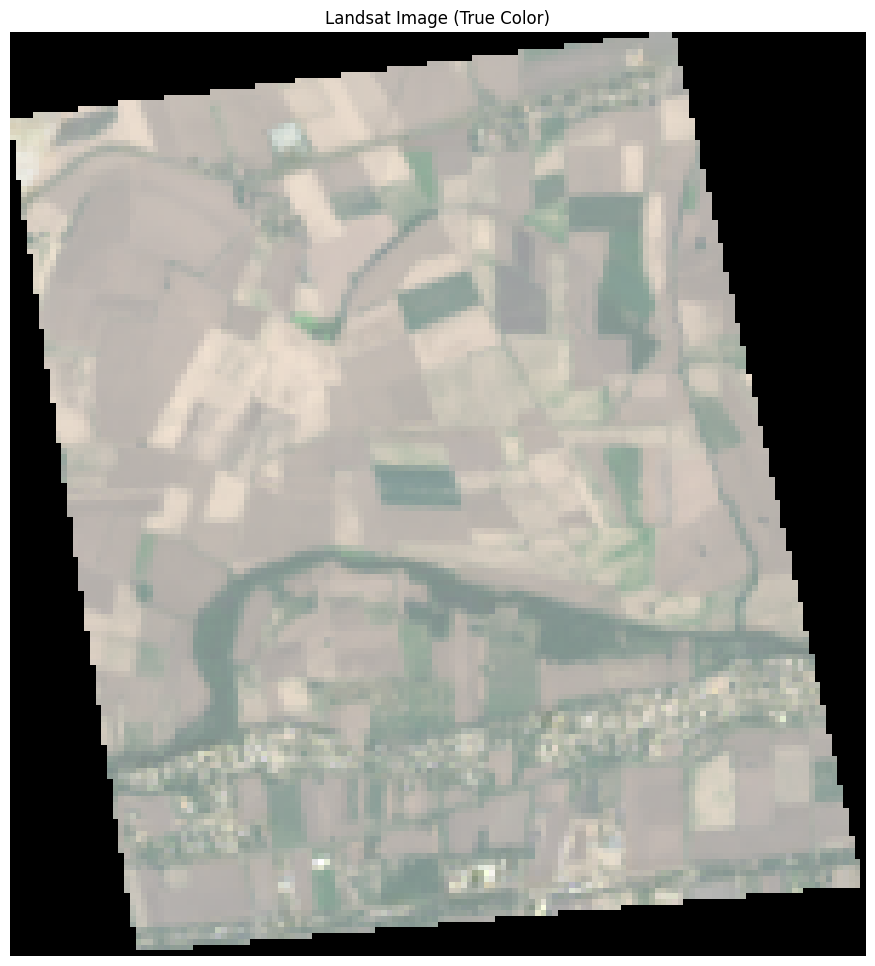

In [34]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the GeoTIFF file
path = "gs://earth_engine_selene/Landsat/Real_Image/Image_2024-10-02 00:00:00.tif"

# Open the GeoTIFF file
with rasterio.open(path) as src:
    # Read the RGB bands
    red = src.read(1)  # Band 1
    green = src.read(2)  # Band 2
    blue = src.read(3)  # Band 3

    # Normalize the bands (for better visualization)
    red = np.clip(red / red.max(), 0, 1)
    green = np.clip(green / green.max(), 0, 1)
    blue = np.clip(blue / blue.max(), 0, 1)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red, green, blue))

# Plot the image
plt.figure(figsize=(12, 12))
plt.imshow(rgb_image)
plt.axis('off')  # Turn off axes
plt.title("Landsat Image (True Color)")
plt.show()


## Arreglar esto

3.2) Estimación desde cero

Fuentes a consultar:

https://medium.com/@Riski-Saputra/mapping-land-surface-temperature-lst-using-landsat-8-imagery-in-arcmap-99bd64f2c3fa

https://ris.utwente.nl/ws/portalfiles/portal/147322271/1_s2.0_S030324341930618X_main.pdf


Leer este comentario:

https://gis.stackexchange.com/questions/433305/error-calculating-lst-in-qgis


**Capitulo 36) Heat Islands**



LST is influenced by several factors including solar radiation, land cover type, soil moisture, and human activities. It’s typically measured using remote sensing techniques, primarily from satellites equipped with thermal infrared sensors. These sensors detect emitted thermal radiation from the Earth’s surface, allowing for the calculation of LST.


En este notebook se seguira un esquema similar de procesamiento al de la siguiente imagen:


<div style="text-align: center;">
    <img src="Images/Flow chart LST.png" alt="Descripción de la imagen" width="500">
</div>




Conceptos relevantes:

**1) SENSOR A UTILIZAR:** 
 
 En este caso utilizaremos el satelite landsat 9 debido a su sensor infrarrojo térmico (Thermal Infrared Sensor (TIRS)), este se encuentra en la banda 10 y captura la luz en longitudes de onda de 10.6 - 11.9 µm. Vease la sigueinte imagen: 
 
<div style="text-align: center;">
    <img src="Images/Banda 10 landsat 9.png" alt="Descripción de la imagen" width="500">
</div>
 
Esta banda tiene una resolución spacial de 30 metros. The Thermal Band (B10) represents land surface temperature but needs scaling.


**2) CALCULOS** 

Las imagenes (archivos raster del satelite) tienen valores en cada pixel. Sin embargo, estos valores no representan necesariamente el fenómeno físico que queremos observar de la imagen. En este caso la temperatura. When you download Landsat 9 Level-2 data, the raw pixel values (called Digital Numbers or DN) must be converted to physical values like reflectance or temperature. This process is called radiometric calibration.

**2.1)  Top of Atmospheric (TOA)**

<div style="text-align: center;">
    <img src="Images/Top of Atmospheric (TOA).png" alt="Descripción de la imagen" width="500">
</div>

Raw Digital Numbers (DN) from Landsat's thermal bands (typically Band 10 for Landsat 8/9) must first be converted to TOA spectral radiance.
TOA radiance accounts for the energy measured by the satellite at the top of the atmosphere, but it does not represent ground temperature directly.

TOA (Top of Atmosphere) se refiere a la cantidad de radiación electromagnética (luz) que es medida por un sensor satelital antes de que haya sido afectada por la atmósfera o la superficie terrestre. En otras palabras, es la radiancia o reflectancia que llega al sensor desde el espacio exterior, proveniente de la superficie terrestre y la atmósfera combinadas.

[Fuentes Top of the Atmosphere (TOA)](https://www.un-spider.org/node/10958)


**2.2)  Top of Atmosphere Brightness-Temperature (TOA BT)**
  
A partir de esta medición electromagnetica TOA (Top of Atmosphere) spectral radiance, es posible calcular la tempertura también en la alta atmosfera. Esto se hace con la siguiente ecuación: 


<div style="text-align: center;">
    <img src="Images/Top of atmosphere temperature.png" alt="Descripción de la imagen" width="500">
</div>


El Top of Atmosphere Brightness Temperature (TOA BT) **es la temperatura aparente** de un objeto negro que emitiría la misma cantidad de radiación que la observada en la parte superior de la atmósfera (TOA) por el sensor del satélite. Se calcula a partir de la radiancia espectral TOA    (𝐿𝜆) y representa una medida de temperatura, pero aún no refleja la temperatura real de la superficie terrestre debido a los efectos de la atmósfera.

TOA Brightness Temperature (TOA BT) es la temperatura derivada directamente de la radiancia captada por el sensor sin correcciones atmosféricas ni de emisividad.


**2.3) Cálculo del NVDI**

 NDVI is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health. NDVI is calculated as a ratio between the red (R) and near infrared (NIR) values in traditional fashion. In landsat-8, NIR values is in Band 5 and R values is in Band 4.


<div style="text-align: center;">
    <img src="Images/NDVI.png" alt="Descripción de la imagen" width="500">
</div>



**2.4) Cálculo del Proportion of Vegetation (PV)**

PV is defined as the ratio of the vertical projection area of vegetation (containing leaves, stalks, and branches) on the ground to the total vegetation area (Deardorff, 1978).

La Proporción de Vegetación (PV) es una estimación de la cantidad de vegetación que cubre un píxel individual en una imagen satelital. No se refiere a toda la imagen, sino que se calcula píxel por píxel. Su propósito es estimar qué fracción de la superficie está cubierta por vegetación, lo que influye directamente en el cálculo de la emisividad (E).

<div style="text-align: center;">
    <img src="Images/PV.png" alt="Descripción de la imagen" width="500">
</div>


<div style="text-align: center;">
    <img src="Images/PV interpratacion.png" alt="Descripción de la imagen" width="500">
</div>


**2.5) Land Surface Temperature**


<div style="text-align: center;">
    <img src="Images/LST.png" alt="Descripción de la imagen" width="500">
</div>




In [43]:
# Define Area of Interest (AOI)
aoi = ee.Geometry.Point([-99.1332, 19.4326])  # Example: Mexico City

# Load Landsat 9 Surface Reflectance Collection
landsat9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
             .filterBounds(aoi) \
             .filterDate('2023-01-01', '2023-12-31') \
             .filterMetadata('CLOUD_COVER', 'less_than', 10)

In [44]:
# Select the most recent image
image = landsat9.first()

In [45]:
# Visualize the True Color Composite
true_color = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0,
    'max': 30000,
    'gamma': 1.4
}

# Apply Scaling Factors (Required for L2 products)
def scale_image(image):
    sr = image.select('SR_B.*').multiply(0.0000275).add(-0.2)  # Surface Reflectance
    tir = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Thermal Band 10
    return image.addBands(sr, overwrite=True).addBands(tir, overwrite=True)

image = scale_image(image)

# Calculate NDVI (for Emissivity Estimation)
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Estimate Land Surface Emissivity (LSE) using NDVI
def calculate_emissivity(ndvi):
    return ndvi.expression(
        '0.004 * NDVI + 0.986', {
            'NDVI': ndvi
        }).rename('Emissivity')

emissivity = calculate_emissivity(ndvi)

# Calculate Land Surface Temperature (LST) in Kelvin
lst = image.select('ST_B10').divide(emissivity).rename('LST')

# Convert LST to Celsius
lst_celsius = lst.subtract(273.15).rename('LST_Celsius')

# Visualization Parameters for LST
lst_vis = {
    'min': 20,
    'max': 40,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}

# Display on Map
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(image, true_color, "Landsat 9 True Color")
Map.addLayer(lst_celsius, lst_vis, "Land Surface Temperature (°C)")
Map

Map(center=[19.432599999999997, -99.1332], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

### 3.3) Visualización de resultados

In [58]:
# Select only the LST band
lst_band = lst_composite.select('LST_C')

In [60]:
# Create a map
Map = geemap.Map(center=[19.4326, -99.1332], zoom=10)

# Define visualization parameters for temperature (in Celsius)
# Adjust min/max according to typical LST values in your area
lst_vis_params = {
    'min': 10,   # Example lower bound in °C
    'max': 45,   # Example upper bound in °C
    'palette': ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
}

# Add the LST layer to the map
Map.addLayer(lst_band, lst_vis_params, 'LST (Celsius)')

# Display the map
Map

Map(center=[19.4326, -99.1332], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

**INSPECCION DE PROPIEDADES**

In [46]:
# Propiedades: 
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
    
# Inpseccionamos los metadados de la imagen 

# Temperatura máxima 
max_temp= k1 = image.get('TEMPERATURE_MAXIMUM_BAND_ST_B10').getInfo()
max_temp = max_temp -273.15

# Temperatura minima 


# Algoritmo utilizado para el cálculo de la temp superficial 
LST_algoritm = image.get('ALGORITHM_SOURCE_SURFACE_TEMPERATURE').getInfo()

#Hora de la imagen 
scene_time = LST_algoritm = image.get('SCENE_CENTER_TIME').getInfo() # Esto esta en UTC, se tiene que corregir, en el caso de la ciudad de mexico es -6 horas, por lo que esto es alrededor de las 10 de la maañana com 59 minutos 


print ("Temperatura máxima leida por el sensor en Celcius:", max_temp)
print ("Algoritmo utilizado para la estimación de la temperatura superficial:",LST_algoritm)
print ("Hora de la imagen:",scene_time)

max_temp

Temperatura máxima leida por el sensor en Celcius: 99.849941
Algoritmo utilizado para la estimación de la temperatura superficial: 16:59:58.2162960Z
Hora de la imagen: 16:59:58.2162960Z


99.849941

**NOTAS ADICIONALES**


**Hora de la temperatura:** 
Landsat satellites (including Landsat 9) have a near-polar, sun-synchronous orbit, which means they generally pass over any given location at (roughly) the same local time on each revisit. For Landsat 8 and 9, the local equatorial crossing time is around 10:00–10:15 a.m. solar time. Consequently, the temperature you see from a single Landsat scene typically corresponds to a mid-morning overpass.


Converting to Local Time

If you want to know what local time that corresponds to, you have to subtract or add your local UTC offset. For example, if your local time zone is UTC-6 (like Central Standard Time in Mexico City for part of the year):

Local Time≈16:59:58UTC−6 hours=10:59:58local



In [23]:
import ee
import geemap

# Inicializar Earth Engine
ee.Initialize()

# Definir el área de interés (Ciudad de México)
aoi = ee.Geometry.Point([-99.1332, 19.4326])

# Cargar Landsat 9 Level 2 Collection (LST ya corregida)
landsat9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
             .filterBounds(aoi) \
             .filterDate('2023-01-01', '2023-12-31') \
             .filterMetadata('CLOUD_COVER', 'less_than', 10)

# Seleccionar la primera imagen
image = landsat9.first()

# Obtener el valor máximo de temperatura desde los metadatos
temperature_max = image.get('TEMPERATURE_MAXIMUM_BAND_ST_B10').getInfo()

print(f"Valor máximo de temperatura (K): {temperature_max}")

# Convertir Temperatura de Superficie (ST_B10) de Kelvin a Celsius
lst_celsius = image.select('ST_B10').subtract(273.15).rename('LST_Celsius')

# Visualización de la imagen en color verdadero (True Color Composite)
true_color = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0,
    'max': 30000,
    'gamma': 1.4
}

# Visualización de la temperatura de superficie (LST)
lst_vis = {
    'min': 20,  # Rango típico de temperatura en °C
    'max': 40,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}

# Mostrar en mapa
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(image, true_color, "Landsat 9 True Color")
Map.addLayer(lst_celsius, lst_vis, "Land Surface Temperature (°C)")
Map


Valor máximo de temperatura (K): 372.999941


Map(center=[19.432599999999997, -99.1332], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…